### Information Retrieval Coursework (STW7071CEM)

Task: Develop a document clustering system.

First, collect a number of documents that belong to different categories, namely Sport, Health and Business. Each document should be at least one sentence (the longer is usually the better). The total number of documents is up to you but should be at least 100 (the more is usually the better).

Once you have collected sufficient documents, cluster them using a standard clustering method (e.g. K-means).

Finally, use the created model to assign a new document to one of the existing clusters. That is, the user enters a document (e.g. a sentence) and your system outputs the right cluster.

### Importing Modules

In [1]:
import os
import string

# Data Handling and Processing
import pandas as pd
import numpy as np
import re
# from scipy import interp


# # Visualuzation
import matplotlib.pyplot as plt
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

# NLP Packages
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk
from joblib import dump, load


# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier

# Scikit Learn packages
from sklearn.base import clone
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

ModuleNotFoundError: No module named 'pandas'

### Load Dataset

SyntaxError: invalid syntax (1048225456.py, line 1)

In [19]:
df = pd.read_csv('database_csv.csv',encoding='latin1')
df = df[df['Cluster_Name'].isin(['Politics','Entertainment','Economics'])]
print(df.shape)
df.head()


(111, 3)


,Document,Cluster,Cluster_Name
0,Trying to understand it for the first time or ...,1.0,Politics
1,President Biden has upended the 2024 White Ho...,1.0,Politics
2,The junior senator from Ohio shot to fame writ...,1.0,Politics
3,A very quick guide to Donald Trump's life story.,1.0,Politics
4,The daughter of an Indian-born mother and Jama...,1.0,Politics


In [20]:
print(df.columns)

Index(['Document', 'Cluster', 'Cluster_Name'], dtype='object')


In [21]:
df.drop(columns=['Cluster'], inplace=True)
df.head()

,Document,Cluster_Name
0,Trying to understand it for the first time or ...,Politics
1,President Biden has upended the 2024 White Ho...,Politics
2,The junior senator from Ohio shot to fame writ...,Politics
3,A very quick guide to Donald Trump's life story.,Politics
4,The daughter of an Indian-born mother and Jama...,Politics


### Exploring the Dataset

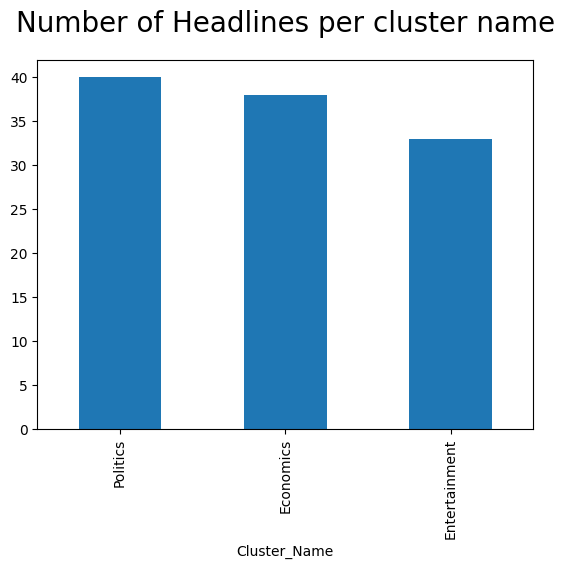

In [34]:
df['Cluster_Name'].value_counts().plot(kind='bar')
plt.title('Number of Headlines per cluster name', size=20, pad=20);

In [25]:
#Checking for missing values
df.isna().sum()

Document        0
Cluster_Name    0
dtype: int64

### Text Preprocessing

We will now clean the text by removing special characters and punctuations.

In [26]:
def preprocess(df):
    # Remove special characters
    df['Document-pro'] = df['Document'].replace('\n',' ')
    df['Document-pro'] = df['Document-pro'].replace('\r',' ')
    
    # Remove punctuation and lowercase
    df['Document-pro'] = df['Document-pro'].str.lower()
    df['Document-pro'] = df['Document-pro'].str.translate(str.maketrans('','',string.punctuation))
    
    # Remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    def fwpt(each):
        tag = pos_tag([each])[0][1][0].upper()
        hash_tag = {"N": wordnet.NOUN,"R": wordnet.ADV, "V": wordnet.VERB,"J": wordnet.ADJ}
        return hash_tag.get(tag, wordnet.NOUN)


    def lematize(text):
        tokens = nltk.word_tokenize(text)
        ax = ""
        for each in tokens:
            if each not in stop_words:
                ax += lemmatizer.lemmatize(each, fwpt(each)) + " "
        return ax

    df['Document-pro'] = df['Document-pro'].apply(lematize)

In [27]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [28]:
preprocess(df)

### Preprocessing Demonstration

**Before Pre-processing:**

In [29]:
df.iloc[0]['Document']

'Trying to understand it for the first time or need a refresher? This guide can help.'

**After Pre-processing**

In [30]:
df.iloc[0]['Document-pro']

'try understand first time need refresher guide help '

### Train Test Split

In [31]:
x_train, x_test, y_train, y_test = train_test_split(df['Document-pro'],
                                                    df['Cluster_Name'],
                                                    test_size=0.25,
                                                    random_state=42)

Check for acceptable category balance

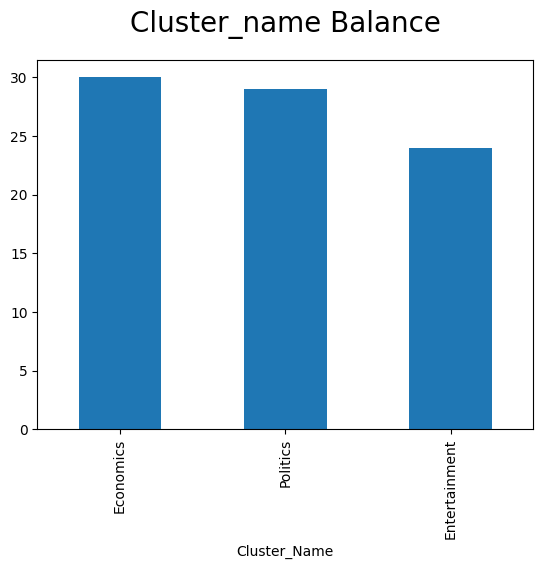

In [35]:
y_train.value_counts().plot(kind='bar')
plt.title('Cluster_name Balance', size=20, pad=20);

In [36]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(83,) (28,) (83,) (28,)


### Vectorize

In [37]:
vector = TfidfVectorizer(stop_words='english',
                        ngram_range = (1,2),
                        min_df = 3,
                        max_df = 0.7,
                        max_features = 10000)

In [ ]:
# Fit Decision Tree Model
def fit_decision_tree(x_train, y_train):
    line = Pipeline([('vectorize', vector), ('DecisionTree', DecisionTreeClassifier())])
    line.fit(x_train, y_train)
    return line

decision_tree_model = fit_decision_tree(x_train, y_train)

# Evaluate the Decision Tree Model
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='weighted')
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

decision_tree_metrics = evaluate_model(decision_tree_model, x_test, y_test)
print(f"Decision Tree Metrics:\nAccuracy: {decision_tree_metrics[0]}\nPrecision: {decision_tree_metrics[1]}\nRecall: {decision_tree_metrics[2]}\nF1 Score: {decision_tree_metrics[3]}")

In [ ]:
# Fit KMeans Model
def fit_kmeans(x_train):
    line = Pipeline([('vectorize', vector), ('KMeans', KMeans(n_clusters=3, random_state=42))])
    line.fit(x_train)
    return line

kmeans_model = fit_kmeans(x_train)

# Predict with KMeans Model
def predict_kmeans(model, x_test):
    return model.predict(x_test)

kmeans_predictions = predict_kmeans(kmeans_model, x_test)
print(f"KMeans Cluster Predictions: {np.unique(kmeans_predictions, return_counts=True)}")

### Model Construction

In [38]:
def fit_model(model, model_name):
    line = Pipeline([('vectorize', vector), (model_name, model)])
    
    output = cross_validate(line, x_train, y_train,
                            cv = KFold(shuffle = True,
                                       n_splits=3,
                                       random_state=42),
                            scoring = ('accuracy', 'f1_weighted','precision_weighted','recall_weighted'),
                            return_train_score=True, error_score='raise')
    return output

In [39]:
decisiontree = fit_model(DecisionTreeClassifier(), 'DecisionTree')
ridge = fit_model(RidgeClassifier(), 'Ridge')
bayes = fit_model(MultinomialNB(), 'NaiveBayes')

dt = pd.DataFrame.from_dict(decisiontree)
rc = pd.DataFrame.from_dict(ridge)
bc = pd.DataFrame.from_dict(bayes)

c:\Project\Environment\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
l1 = [bc, rc, dt]
l2 = ["NaiveBayes","Ridge","DecisionTree"]

for each, tag in zip(l1,l2):
    each['model'] = [tag, tag, tag]

joined_output = pd.concat([bc,rc,dt])

In [41]:
decisiontree

{'fit_time': array([0.07605028, 0.0102284 , 0.01602745]),
 'score_time': array([0.03811383, 0.03621006, 0.03099513]),
 'test_accuracy': array([0.46428571, 0.46428571, 0.59259259]),
 'train_accuracy': array([0.8       , 0.81818182, 0.80357143]),
 'test_f1_weighted': array([0.46545455, 0.47619048, 0.55688509]),
 'train_f1_weighted': array([0.79389032, 0.81974026, 0.80556379]),
 'test_precision_weighted': array([0.64583333, 0.52721088, 0.61111111]),
 'train_precision_weighted': array([0.86470588, 0.86363636, 0.85595238]),
 'test_recall_weighted': array([0.46428571, 0.46428571, 0.59259259]),
 'train_recall_weighted': array([0.8       , 0.81818182, 0.80357143])}

In [42]:
ridge

{'fit_time': array([0.03924775, 0.03239942, 0.03088856]),
 'score_time': array([0.01881099, 0.01656747, 0.01584935]),
 'test_accuracy': array([0.46428571, 0.5       , 0.55555556]),
 'train_accuracy': array([0.78181818, 0.81818182, 0.73214286]),
 'test_f1_weighted': array([0.46545455, 0.50796108, 0.52141932]),
 'train_f1_weighted': array([0.77632368, 0.81974026, 0.72961146]),
 'test_precision_weighted': array([0.64583333, 0.54315476, 0.54298942]),
 'train_precision_weighted': array([0.83962704, 0.86363636, 0.74495266]),
 'test_recall_weighted': array([0.46428571, 0.5       , 0.55555556]),
 'train_recall_weighted': array([0.78181818, 0.81818182, 0.73214286])}

In [43]:
bayes

{'fit_time': array([0.00974226, 0.01959825, 0.01793933]),
 'score_time': array([0.03108907, 0.01698565, 0.07571888]),
 'test_accuracy': array([0.46428571, 0.53571429, 0.14814815]),
 'train_accuracy': array([0.74545455, 0.70909091, 0.53571429]),
 'test_f1_weighted': array([0.46545455, 0.49349206, 0.04389575]),
 'train_f1_weighted': array([0.73913753, 0.67727851, 0.48487658]),
 'test_precision_weighted': array([0.64583333, 0.67633929, 0.0257649 ]),
 'train_precision_weighted': array([0.84176904, 0.76414439, 0.52997449]),
 'test_recall_weighted': array([0.46428571, 0.53571429, 0.14814815]),
 'train_recall_weighted': array([0.74545455, 0.70909091, 0.53571429])}

In [44]:
relevant_measures = list(['test_accuracy', 'test_precision_weighted', 'test_recall_weighted',  'test_f1_weighted'])


dec_tree_metrics = joined_output.loc[joined_output.model == 'DecisionTree'][relevant_measures]
nb_metrics = joined_output.loc[joined_output.model == 'NaiveBayes'][relevant_measures]
r_metrics = joined_output.loc[joined_output.model == 'Ridge'][relevant_measures]

Decision Tree Metrics

In [45]:
dec_tree_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.464286,0.645833,0.464286,0.465455
1,0.464286,0.527211,0.464286,0.476190
2,0.592593,0.611111,0.592593,0.556885


Multinomial Naive Bayes Metrics

In [46]:
nb_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.464286,0.645833,0.464286,0.465455
1,0.535714,0.676339,0.535714,0.493492
2,0.148148,0.025765,0.148148,0.043896


Ridge Classifier Metrics

In [47]:
r_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.464286,0.645833,0.464286,0.465455
1,0.500000,0.543155,0.500000,0.507961
2,0.555556,0.542989,0.555556,0.521419


Average Metrics

In [48]:
metrics_ = [dec_tree_metrics, nb_metrics, r_metrics]
names_ = ['Decision Tree', 'Naive Bayes', 'Ridge Classifier']

for scores, names in zip(metrics_, names_):
    print(f'{names} Mean Metrics:')
    print(scores.mean())
    print(" ")

Decision Tree Mean Metrics:
test_accuracy              0.507055
test_precision_weighted    0.594718
test_recall_weighted       0.507055
test_f1_weighted           0.499510
dtype: float64
 
Naive Bayes Mean Metrics:
test_accuracy              0.382716
test_precision_weighted    0.449313
test_recall_weighted       0.382716
test_f1_weighted           0.334281
dtype: float64
 
Ridge Classifier Mean Metrics:
test_accuracy              0.506614
test_precision_weighted    0.577326
test_recall_weighted       0.506614
test_f1_weighted           0.498278
dtype: float64
 


### Selecting a Model

We can see from the metrics above that Ridge Classifier performs the best among three. However, we will be choosing the Multinomial Naive Bayes Classifier as the final model due to it's ability to provide probability score for each prediction.

In [49]:
x = pd.concat([x_train,
               x_test])
y = pd.concat([y_train,
               y_test])

In [50]:
def create_and_fit(clf, x, y):
    best_clf = clf
    pipeline = Pipeline([('vectorize',vector), ('model',best_clf)])
    return pipeline.fit(x,y)

In [51]:
classifier = create_and_fit(MultinomialNB(),x,y)

In [52]:
classifier.classes_

array(['Economics', 'Entertainment', 'Politics'], dtype='<U13')

### Final Testing

This text is extracted through Google News from the Business Section.
The classifier should predict the text as "BUSINESS"

In [32]:
input_text = 'A 34%, three-day surge in SoftBank Group Corp. has pushed its shares to the most overbought level in more than two decades on the back of Arm Holdings Plc.’s explosive rally.'
classifier.predict_proba([input_text])

array([[0.43035041, 0.2765513 , 0.29309829]])

In [33]:
classifier.predict([input_text])[0]

'BUSINESS'

### GUI

In [36]:
import tkinter as tk
from tkinter.scrolledtext import ScrolledText


window = tk.Tk()


window.title("TEXT CLASSIFIER")
window.minsize(600,400)

text_box = ScrolledText(window)
text_box.grid(column=0, row=1, padx=5, pady=5)

def result(res, pr):
    BUSINESS = round(pr[0][0], 3)
    HEALTH = round(pr[0][1], 3)
    SPORTS = round(pr[0][2], 3)
    
    lines = [f"Health: {HEALTH}", f"Business: {BUSINESS}", f"Sports: {SPORTS}"]
    tk.messagebox.showinfo(message= f"Predicted Category: {str(res).capitalize()}" + "\n\n\n"+"\n".join(lines))

def clickMe():
    classification = tk.StringVar()
    category_,probabilities = classify_text(text_box.get("1.0",tk.END))
    result(category_, probabilities)
    

def classify_text(input_text):
    out = classifier.predict([input_text])[0]
    probs = classifier.predict_proba([input_text])
    return out,probs

label = tk.Label(window, text = "Enter Text to be classified")
label.grid(column = 0, row = 0)

btn = tk.Button(window, text="Classify", command=clickMe)
btn.grid(column=0, row=2)


window.mainloop()